In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sentence_transformers import SentenceTransformer, util
import torch 
from torch.utils.data import DataLoader

from tqdm import tqdm

# Load the dataset (replace with your dataset path)
df = pd.read_csv('train.csv')

# Drop rows with missing values
df = df.dropna()

df = df.head(100000)

# Preprocessing (lowercase and strip whitespace)
df['question1'] = df['question1'].str.lower().str.strip()
df['question2'] = df['question2'].str.lower().str.strip()

In [7]:

# Step 2: Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 3: Process data in smaller chunks
chunk_size = 5000
similarities = []
q1_embeddings_list = []
q2_embeddings_list = []

def process_chunk(chunk):
    # Encode questions into embeddings
    q1_embeddings = model.encode(chunk['question1'].tolist(), convert_to_tensor=True)
    q2_embeddings = model.encode(chunk['question2'].tolist(), convert_to_tensor=True)
    q1_embeddings_list.append(q1_embeddings.cpu().numpy())
    q2_embeddings_list.append(q2_embeddings.cpu().numpy())
    # Compute cosine similarity
    return util.cos_sim(q1_embeddings, q2_embeddings).cpu().numpy()

# Iterate over chunks
for start in range(0, len(df), chunk_size):
    end = min(start + chunk_size, len(df))
    chunk = df.iloc[start:end]
    chunk_similarities = process_chunk(chunk)
    similarities.append(np.diagonal(chunk_similarities))

# Combine all similarities
df['similarity'] = np.concatenate(similarities)

# Combine all embeddings for PCA
q1_embeddings = np.vstack(q1_embeddings_list)
q2_embeddings = np.vstack(q2_embeddings_list)

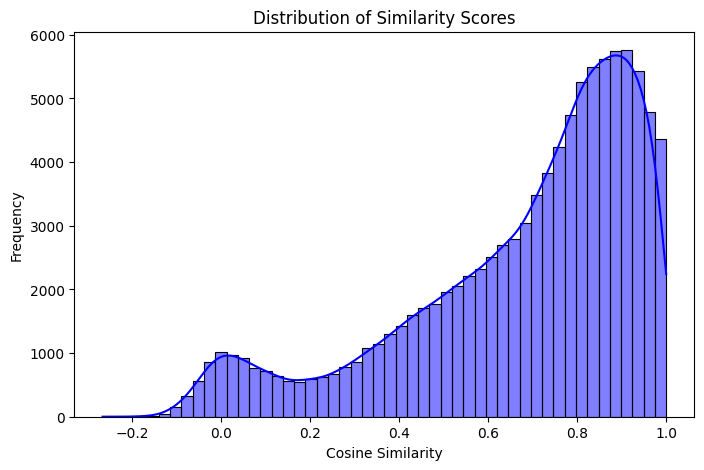

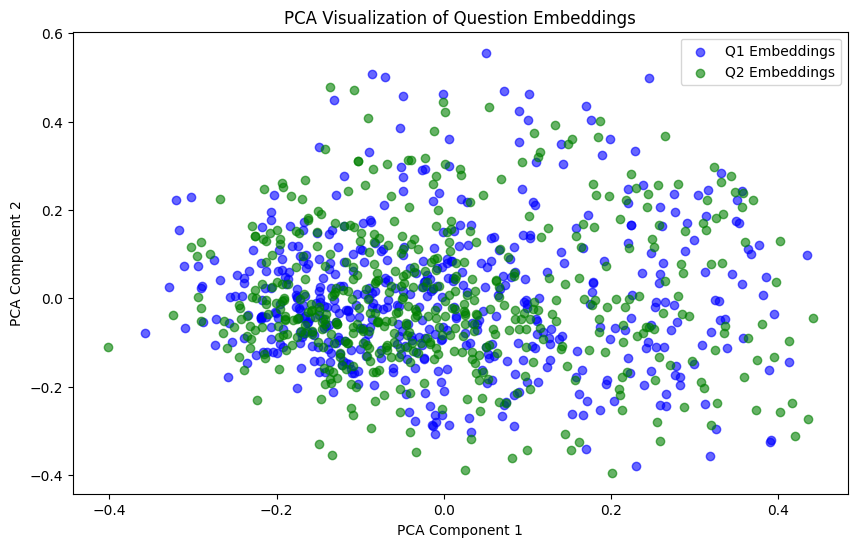

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/christiesam/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/christiesam/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


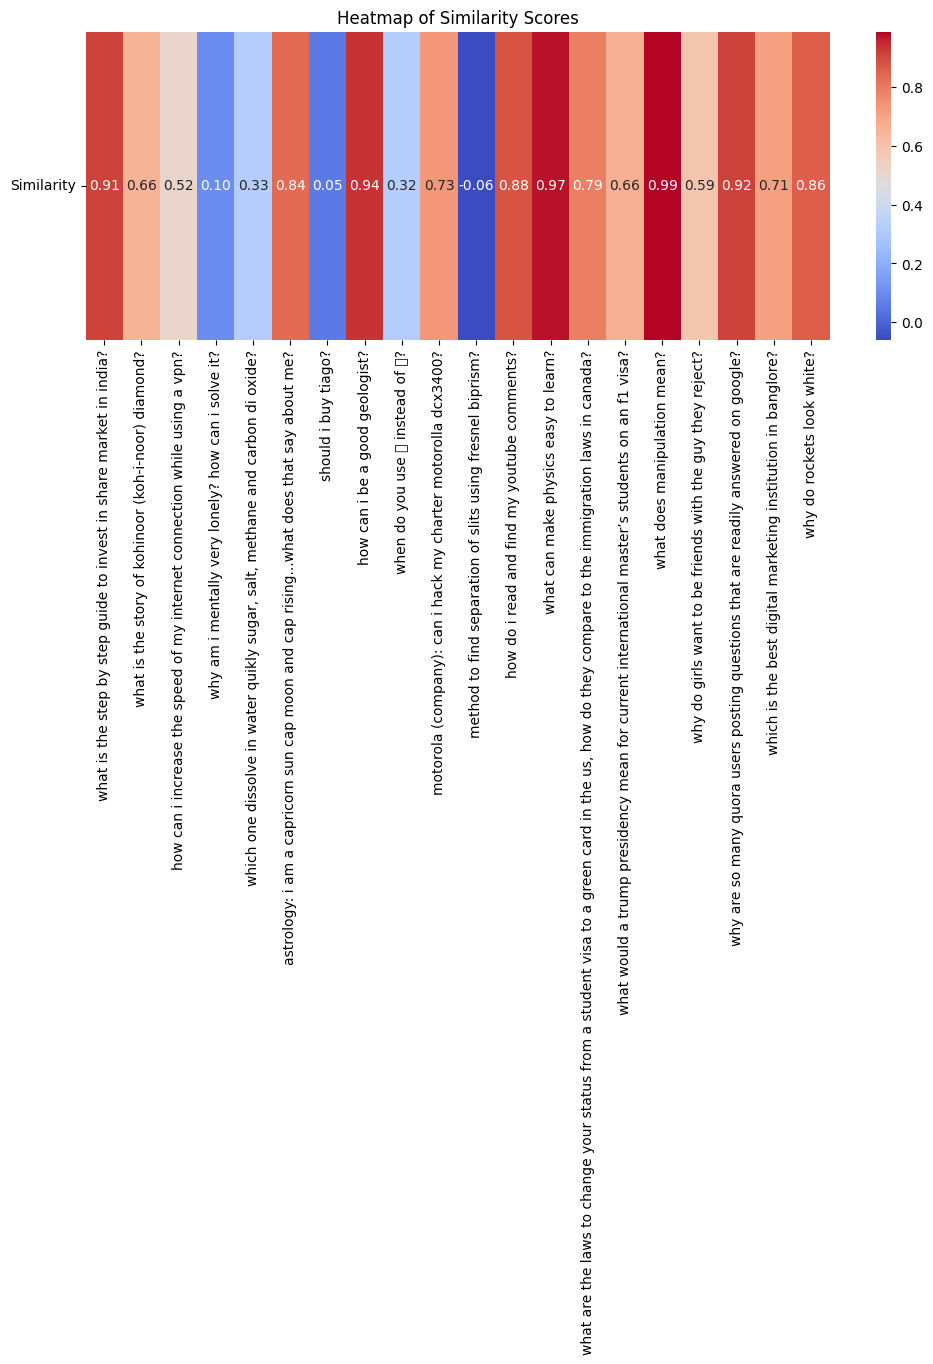

In [8]:
# Step 4: Handle invalid values in embeddings
q1_embeddings = np.nan_to_num(q1_embeddings, nan=0.0, posinf=0.0, neginf=0.0)
q2_embeddings = np.nan_to_num(q2_embeddings, nan=0.0, posinf=0.0, neginf=0.0)

import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Visualizations
# 1. Distribution of similarity scores
plt.figure(figsize=(8, 5))
sns.histplot(df['similarity'], bins=50, kde=True, color='blue')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

# Step 4: Visualizations
# 2. Dimensionality reduction of embeddings
pca = PCA(n_components=2)
q1_pca = pca.fit_transform(q1_embeddings[:500])  # Subset for visualization
q2_pca = pca.fit_transform(q2_embeddings[:500])  # Subset for visualization

plt.figure(figsize=(10, 6))
plt.scatter(q1_pca[:, 0], q1_pca[:, 1], alpha=0.6, label='Q1 Embeddings', color='blue')
plt.scatter(q2_pca[:, 0], q2_pca[:, 1], alpha=0.6, label='Q2 Embeddings', color='green')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Question Embeddings")
plt.legend()
plt.show()

# Step 4: Visualizations
# 3. Heatmap of similarity scores
# Combine all similarity arrays into a single numpy array
similarities_combined = np.concatenate(similarities, axis=0)
# Take a subset of the first 20 similarity scores
subset = df.iloc[:20]
heatmap_data = np.expand_dims(similarities_combined[:20], axis=0)  # Expand to 2D for heatmap

# Plot the heatmap
plt.figure(figsize=(12, 4))  # Adjust aspect ratio for a single-row heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm', 
            xticklabels=subset['question1'], yticklabels=['Similarity'])
plt.title('Heatmap of Similarity Scores')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [9]:
# Step 5: Linear Regression Model
# Use similarity as response variable and text-based features as predictors
df['q1_length'] = df['question1'].apply(len)
df['q2_length'] = df['question2'].apply(len)
df['length_diff'] = abs(df['q1_length'] - df['q2_length'])

X = df[['q1_length', 'q2_length', 'length_diff']]
y = df['similarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

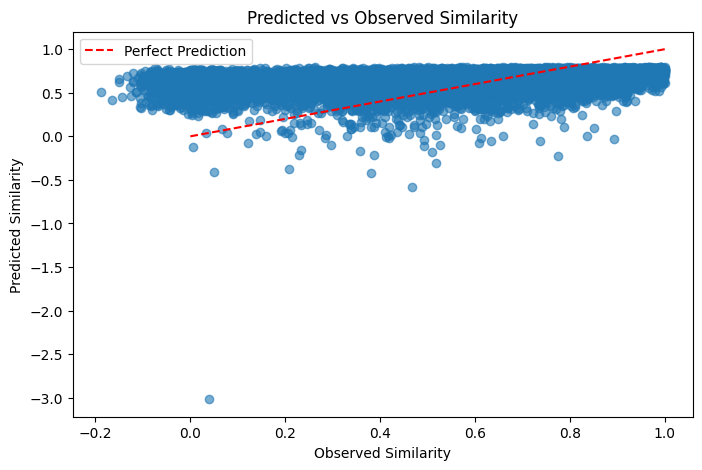

In [10]:
# Step 6: Visualize predictions vs observed values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Observed Similarity')
plt.ylabel('Predicted Similarity')
plt.title('Predicted vs Observed Similarity')
plt.legend()
plt.show()

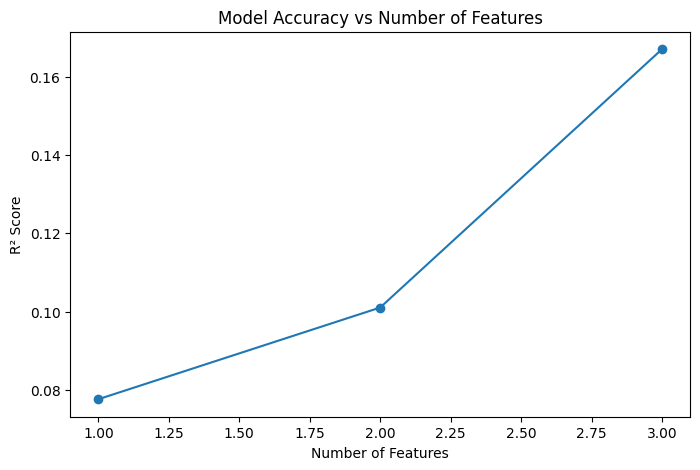

In [11]:
# Step 7: Model Complexity Plot
features = ['q1_length', 'q2_length', 'length_diff']
r2_scores = []
for i in range(1, len(features) + 1):
    X_train_subset = X_train[features[:i]]
    X_test_subset = X_test[features[:i]]
    
    model.fit(X_train_subset, y_train)
    y_pred_subset = model.predict(X_test_subset)
    r2_scores.append(r2_score(y_test, y_pred_subset))

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(features) + 1), r2_scores, marker='o')
plt.title('Model Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.show()